# Scatter matrix

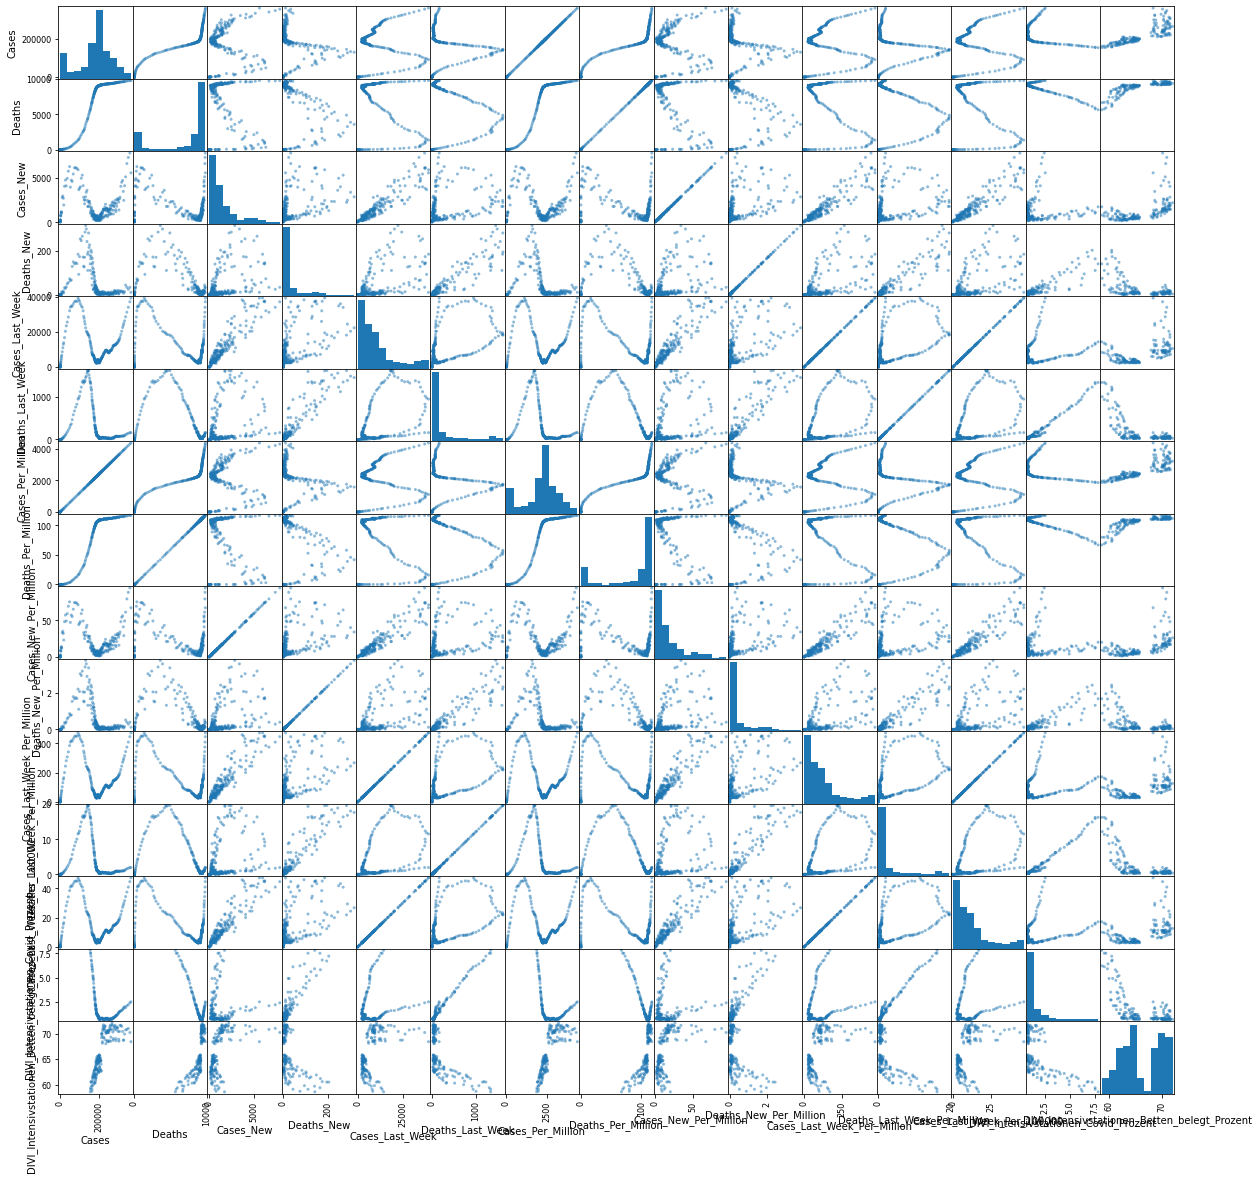

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb

area = 'DE-total'
de = entorb.to_dataframe(area)
de.drop(columns=[c for c in de.columns if "Doubling_Time" in c], inplace=True)
pd.plotting.scatter_matrix(de, figsize=(20,20))
plt.show()

# R²

In [2]:
corr = de.corr()**2
corr.style.background_gradient(cmap='Blues')

,Cases,Deaths,Cases_New,Deaths_New,Cases_Last_Week,Deaths_Last_Week,Cases_Per_Million,Deaths_Per_Million,Cases_New_Per_Million,Deaths_New_Per_Million,Cases_Last_Week_Per_Million,Deaths_Last_Week_Per_Million,Cases_Last_Week_Per_100000,DIVI_Intensivstationen_Covid_Prozent,DIVI_Intensivstationen_Betten_belegt_Prozent
Cases,1.000000,0.841049,0.001013,0.061629,0.000372,0.049761,1.000000,0.840181,0.001038,0.061640,0.000369,0.049742,0.000369,0.177904,0.661319
Deaths,0.841049,1.000000,0.090460,0.130724,0.102457,0.098149,0.841035,0.999950,0.090061,0.130743,0.102546,0.098123,0.102546,0.864496,0.586705
Cases_New,0.001013,0.090460,1.000000,0.168412,0.862455,0.086000,0.001015,0.091474,0.999777,0.168391,0.862543,0.085996,0.862543,0.001044,0.285713
Deaths_New,0.061629,0.130724,0.168412,1.000000,0.297700,0.853810,0.061619,0.131596,0.168493,1.000000,0.297444,0.853824,0.297444,0.809055,0.262320
Cases_Last_Week,0.000372,0.102457,0.862455,0.297700,1.000000,0.221886,0.000373,0.103638,0.863234,0.297684,0.999994,0.221868,0.999994,0.017886,0.232229
Deaths_Last_Week,0.049761,0.098149,0.086000,0.853810,0.221886,1.000000,0.049751,0.098736,0.086458,0.853798,0.221644,1.000000,0.221644,0.980030,0.403562
Cases_Per_Million,1.000000,0.841035,0.001015,0.061619,0.000373,0.049751,1.000000,0.840167,0.001040,0.061631,0.000370,0.049732,0.000370,0.177867,0.661303
Deaths_Per_Million,0.840181,0.999950,0.091474,0.131596,0.103638,0.098736,0.840167,1.000000,0.091073,0.131614,0.103728,0.098709,0.103728,0.865276,0.585137
Cases_New_Per_Million,0.001038,0.090061,0.999777,0.168493,0.863234,0.086458,0.001040,0.091073,1.000000,0.168471,0.863320,0.086454,0.863320,0.001117,0.284368
Deaths_New_Per_Million,0.061640,0.130743,0.168391,1.000000,0.297684,0.853798,0.061631,0.131614,0.168471,1.000000,0.297428,0.853812,0.297428,0.808997,0.262267


# Deaths formula:

Deaths(Cases) = 
               4                 3                 2
8.359e-18 Cases - 6.772e-12 Cases + 1.678e-06 Cases - 0.08967 Cases + 437.9


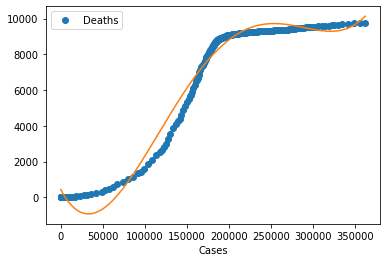

In [3]:
import numpy as np
coefs = np.polyfit(x=de['Cases'], y=de['Deaths'], deg=4)
de.plot(kind='line', x='Cases', y='Deaths', linestyle='', marker='o')
poly = np.poly1d(coefs, variable='Cases')
plt.plot(de['Cases'], poly(de['Cases']))
print("Deaths(Cases) = ")
print(poly)

-13.339707729162422

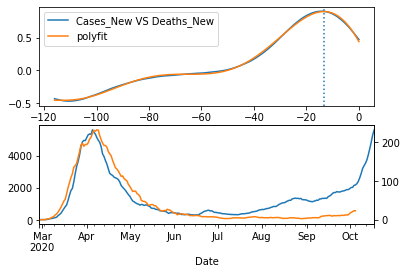

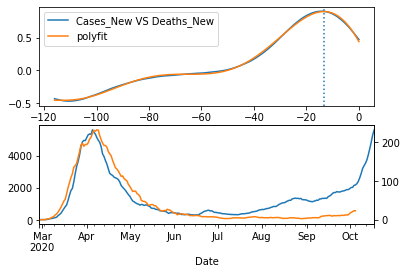

In [4]:
overlapping_days = int(0.5 * min([len(de['Cases_New']), len(de['Deaths_New'])]))

lcor = lagged_correlation = pd.DataFrame.from_dict(
    {'Cases_New VS Deaths_New': [de['Cases_New'].rolling('7D').mean().corr(de['Deaths_New'].rolling('7D').mean().shift(-t)) for t in range(overlapping_days)],
     'Delta_New': [-t for t in range(overlapping_days)]}).set_index('Delta_New')

fig, axes = plt.subplots(nrows=2)

poly = np.poly1d(np.polyfit(x=lcor.index, y=lcor['Cases_New VS Deaths_New'], deg=7), variable='r')
lag = [x.real for x in poly.deriv().r if x.imag==0 and x.real<0][-1]
display(lag)

lcor.plot(ax=axes[0])
axes[0].plot(lcor.index, poly(lcor.index), label="polyfit")
axes[0].axvline(lag, linestyle=':')
axes[0].legend()

de['Cases_New'].rolling('7D').mean().plot(ax=axes[1])
de['Deaths_New'].rolling('7D').mean().shift(int(lag)).plot(ax=axes[1], secondary_y=True)
display(fig)